In [1]:
# Previous examples use the shifted target sequence as decoder input.
# Here we use the generated sequence as decoder input.
# The key is the usage of the function tf.nn.raw_rnn and the design of the function loop_fn.

In [148]:
x = [[5, 7, 8], [6, 3], [3], [1]]

In [185]:
import helpers
xt, xlen = helpers.batch(x)

In [186]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

In [187]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import control_flow_ops
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [188]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [189]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
encoder_inputs_len = tf.placeholder(shape=(None), dtype=tf.int32, name='encoder_inputs_len')

In [190]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

In [191]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [192]:
encoder_inputs_embedded

<tf.Tensor 'embedding_lookup:0' shape=(?, ?, 20) dtype=float32>

In [193]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

In [194]:
# note: here bidirectional_dynamic_rnn requires the parameter sequence_length, 
# or it will raise error for not supporting reverse operation to none type.
encoder_outputs, encoder_final_state = tf.nn.bidirectional_dynamic_rnn(
    encoder_cell, encoder_cell, encoder_inputs_embedded,
    sequence_length=encoder_inputs_len,
    dtype=tf.float32, time_major=True,
)

In [195]:
(state_c_fw, state_h_fw), (state_c_bw, state_h_bw) = encoder_final_state

In [196]:
# feed the concatenated the bidirectional rnn's outputs to the decoder.
state_c = tf.concat([state_c_fw, state_c_bw], 1)
state_h = tf.concat([state_h_fw, state_h_bw], 1)

state_c = tf.contrib.layers.fully_connected(state_c, decoder_hidden_units, activation_fn=tf.nn.tanh)
state_h = tf.contrib.layers.fully_connected(state_h, decoder_hidden_units, activation_fn=tf.nn.tanh)

encoder_final_state = tf.contrib.rnn.LSTMStateTuple(state_c, state_h)
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'fully_connected/Tanh:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'fully_connected_1/Tanh:0' shape=(?, 20) dtype=float32>)

In [197]:
# eos_step_embedded for the first decoder input
# pad_step_embedded for the step when it is beyond the decoder length.
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

# here we are doing a toy copy task, so we unroll decoder for len(encoder_input)+2, to allow model some room to make mistakes over 2 additional steps:
# +2 additional steps, +1 leading <EOS> token for decoder inputs
decoder_len = encoder_inputs_len + 3

In [198]:
# define the weight for output.
Wo = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32, name='Wo')
bo = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32, name='bo')

In [199]:
# loop_fn: A callable that takes inputs (time, cell_output, cell_state, loop_state) 
# and returns the tuple (finished, next_input, next_cell_state, emit_output, next_loop_state)

# def loop_fn_initial():
#     initial_elements_finished = (0 >= decoder_len)  # all False at the initial step
#     initial_input = eos_step_embedded
#     initial_cell_state = encoder_final_state
#     initial_cell_output = None
#     initial_loop_state = None  # we don't need to pass any additional information
#     return (initial_elements_finished,
#             initial_input,
#             initial_cell_state,
#             initial_cell_output,
#             initial_loop_state)

# def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):
#     def get_next_input():
#         output_logits = tf.add(tf.matmul(previous_output, Wo), bo)
#         prediction = tf.argmax(output_logits, axis=1)
#         next_input = tf.nn.embedding_lookup(embeddings, prediction)
#         return next_input

#     elements_finished = (time >= decoder_len)  # this operation produces boolean tensor of [batch_size]
#     # defining if corresponding sequence has ended

#     finished = tf.reduce_all(elements_finished)  # -> boolean scalar
#     input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
#     state = previous_state
#     output = previous_output
#     loop_state = None

#     return (elements_finished,
#             input,
#             state,
#             output,
#             loop_state)
# 
# def loop_fn(time, previous_output, previous_state, previous_loop_state):
#     if previous_state is None:    # time == 0
#         assert previous_output is None and previous_state is None
#         return loop_fn_initial()
#     else:
#         return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)
    
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, Wo), bo)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input

    elements_finished = (time >= decoder_len)
    finished = math_ops.reduce_all(elements_finished)
    
    if previous_state is None:    # time == 0
        state = encoder_final_state
        next_input = eos_step_embedded
        output = None
    else:
        state = previous_state
        next_input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
        output = previous_output
    # we don't need to pass any additional information
    loop_state = None 
    
    return (elements_finished,
            next_input,
            state,
            output,
            loop_state)

In [200]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

In [201]:
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [202]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [203]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

In [204]:
decoder_logits

<tf.Tensor 'fully_connected_2/BiasAdd:0' shape=(?, ?, 10) dtype=float32>

In [205]:
decoder_prediction = tf.argmax(decoder_logits, 2)

In [206]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

In [207]:
decoder_prediction

<tf.Tensor 'ArgMax:0' shape=(?, ?) dtype=int64>

In [208]:
stepwise_cross_entropy

<tf.Tensor 'Reshape_2:0' shape=(?, ?) dtype=float32>

In [209]:
loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [210]:
sess.run(tf.global_variables_initializer())

In [211]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[4, 3, 9]
[2, 5, 7, 8, 2, 6, 8]
[8, 2, 4, 8, 7, 2, 8]
[5, 5, 6, 8, 2]
[8, 6, 7, 2, 2, 9, 3, 4]
[6, 4, 7, 7, 3]
[2, 2, 5]
[2, 4, 6, 4, 5, 4, 9]
[9, 7, 5, 7, 7, 2, 8, 5]
[7, 8, 7, 2, 6, 7]


In [212]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_len: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [213]:
loss_track = []

In [214]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.33903312683
  sample 1:
    input     > [6 5 8 0 0 0 0 0]
    predicted > [2 3 3 3 3 3 0 0 0 0 0]
  sample 2:
    input     > [5 2 4 0 0 0 0 0]
    predicted > [2 3 3 3 3 3 0 0 0 0 0]
  sample 3:
    input     > [9 2 2 0 0 0 0 0]
    predicted > [2 3 3 3 3 3 0 0 0 0 0]
()
batch 1000
  minibatch loss: 0.84826952219
  sample 1:
    input     > [6 3 9 2 0 0 0 0]
    predicted > [6 6 2 2 1 0 0 0 0 0 0]
  sample 2:
    input     > [8 7 4 6 5 3 9 3]
    predicted > [8 8 8 8 8 3 3 3 1 0 0]
  sample 3:
    input     > [8 5 7 4 4 5 8 0]
    predicted > [5 5 8 8 8 8 8 1 0 0 0]
()
batch 2000
  minibatch loss: 0.555927097797
  sample 1:
    input     > [3 5 7 2 8 4 0 0]
    predicted > [5 5 7 7 7 8 1 0 0 0 0]
  sample 2:
    input     > [5 7 7 6 3 0 0 0]
    predicted > [7 7 7 7 3 1 0 0 0 0 0]
  sample 3:
    input     > [2 7 3 7 7 4 0 0]
    predicted > [2 7 7 7 7 4 1 0 0 0 0]
()
batch 3000
  minibatch loss: 0.483351498842
  sample 1:
    input     > [7 4 4 7 0 0 0 0]


In [215]:
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

loss 0.4841 after 300100 examples (batch_size=100)


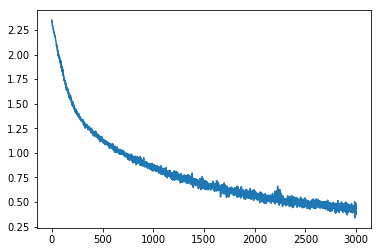

In [216]:
plt.show()